## Pytorch Simple FullyNet
---

Các bước chính gồm:
- Chuẩn bị dữ liệu
- Xây dựng mô hình
- Train mô hình
- Đánh giá mô hình

In [ ]:
# Import thư viện
import torch
import torch.nn.functional as F # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets # Standard datasets
import torchvision.transforms as transforms # Transformations we can perform on our dataset for augmentation
from torch import optim # For optimizers, such as SGD, Adam, etc.
from torch import nn # All neural network modules
from torch.utils.data import (
    DataLoader, random_split
    # Gives easier dataset managment by creating mini batch
)
from tqdm import tqdm # For nice progress bar!


### Xây dựng Class Neural Network


In [ ]:
class NN(nn.Module):
  def __init__(self,input_size: int, number_class: int) -> None:
    """
    Hàm khởi tạo class NN

    Parametter:
      input_size(int): Kích thước đầu vào, là 784 (28x28)
      number_class(int): Số lớp đầu ra, là 10 (0->9)
    """
    super(NN,self).__init__()
    # Our first linear layer take input_size, in this case 784 nodes to 50
    # and our second linear layer takes 50 to the num_classes we have, in
    # this case 10.
    # Tiện lợi, thay vì phải khai báo số hidden layer và số node mỗi layer
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, number_class)

  def forward(self,x):
    """
    x here is the mnist images and we run it through fc1, fc2 that we created above.
    we also add a ReLU activation function in between and for that (since it has no parameters)
    I recommend using nn.functional (F)

    Paramenter:
      x: Image Mnist

    Return:
      out: the output of the neural network
    """
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


### Chuẩn bị dữ liệu

In [ ]:
# set device cuda for GPU if availabel otherwise run on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 3

In [ ]:
# DataLoader

# train_dataset = datasets.MNIST(
#     root="dataset/", train = True, transform=transforms.ToTensor(), download=True
# )
full_train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train = False, transform=transforms.ToTensor(), download = True
)

# Chia train_dataset thành train và validation
train_len = int(0.8 * len(full_train_dataset))
val_len = len(full_train_dataset) - train_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])



train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)



### Train Mô hình

In [ ]:
# Khởi tạo mô hình
model = NN(input_size=input_size, number_class=num_classes).to(device)

# Loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


In [ ]:
# # Train network

# for epoch in range(num_epochs):
#   for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
#     # Get data to cuda if possible
#     data = data.to(device=device)
#     target = targets.to(device=device)

#     # reshape data correct
#     data = data.reshape(data.shape[0], -1)

#     # Forward
#     scores = model(data)
#     loss = criterion(scores, target)

#     # Backward
#     optimizer.zero_grad()
#     loss.backward()

#     # Gradient descent or adam step
#     optimizer.step()


In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)
    model.train()
    return num_correct / num_samples

# Huấn luyện và validate
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        # Get data to gpu if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Reshape data
        data = data.reshape(data.shape[0], -1)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Optimizer
        optimizer.step()

        # Loss of each epoch
        running_loss += loss.item()

    train_acc = check_accuracy(train_loader, model)
    val_acc = check_accuracy(val_loader, model)
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc*100:.2f}% - Val Acc: {val_acc*100:.2f}%")

Epoch 1: 100%|██████████| 750/750 [00:09<00:00, 75.85it/s]


Epoch [1/3] - Train Loss: 0.4532 - Train Acc: 92.60% - Val Acc: 92.09%


Epoch 2: 100%|██████████| 750/750 [00:08<00:00, 91.39it/s] 


Epoch [2/3] - Train Loss: 0.2333 - Train Acc: 94.56% - Val Acc: 93.80%


Epoch 3: 100%|██████████| 750/750 [00:09<00:00, 81.37it/s]


Epoch [3/3] - Train Loss: 0.1809 - Train Acc: 95.45% - Val Acc: 94.67%


### Đánh giá mô hình
---


In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader,model):
  """
  Check accuracy of our train model given loader and a model

  Parameters:
    loader: torch.utils.data.DataLoader

    A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on

    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader

  """
  num_correct = 0
  num_samples = 0
  model.eval()

  # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
  with torch.no_grad():
    # Loop through the data
    for x,y in loader:
      x = x.to(device=device)
      y = y.to(device=device)

      # Correct shape
      x = x.reshape(x.shape[0], -1)

      # Forward pass
      scores = model(x)
      _, predictions = scores.max(1)

      # Check how many we got correct
      num_correct += (predictions == y).sum()

      # keep track of numer of samples
      num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples






In [ ]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 95.45
Accuracy on test set: 94.89


### Dự đoán một image bất kì

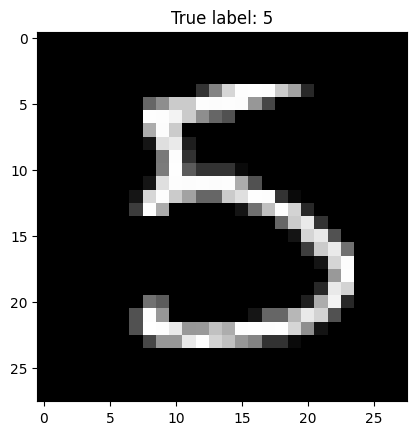

Model prediction: 5


In [ ]:
import torch
import matplotlib.pyplot as plt

# Giả sử model đã được train và ở chế độ eval
model.eval()

# Lấy một ảnh bất kỳ từ test_dataset
idx = 15 # chọn index bất kỳ, bạn có thể thay đổi số này
image, label = test_dataset[idx]

# Hiển thị ảnh
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'True label: {label}')
plt.show()

# Dự đoán
with torch.no_grad():
    img = image.reshape(1, -1).to(device) # reshape về [1, 784] và đưa lên GPU/CPU
    output = model(img)
    _, predicted = torch.max(output, dim=1)

print(f'Model prediction: {predicted.item()}')

---


## 1. **Import các thư viện**
- **torch, torch.nn, torch.optim**: Thư viện chính để xây dựng và tối ưu hóa mạng neural.
- **torchvision.datasets, torchvision.transforms**: Dùng để lấy bộ dữ liệu MNIST và chuyển đổi thành tensor.
- **torch.utils.data.DataLoader**: Giúp chia dữ liệu thành các batch nhỏ để huấn luyện dễ dàng hơn.
- **tqdm**: Hiển thị thanh tiến trình khi huấn luyện.

## 2. **Xây dựng mô hình mạng neural**
- Định nghĩa class `NN`, kế thừa từ `nn.Module`.
- Trong `__init__`, tạo 2 lớp fully connected (linear):
    - `fc1`: input_size (784) → 50 nodes.
    - `fc2`: 50 nodes → num_classes (10).
- Trong hàm `forward`, dữ liệu đi qua:
    - Lớp fc1 → hàm kích hoạt ReLU → lớp fc2.
- Đây là mạng neural đơn giản: chỉ 2 lớp linear.

## 3. **Thiết lập thiết bị (GPU/CPU)**
- Kiểm tra nếu máy có GPU (CUDA) thì dùng, không thì dùng CPU.

## 4. **Khai báo các hyperparameter**
- `input_size = 784`: Mỗi ảnh MNIST là 28x28, làm phẳng thành 784 điểm ảnh.
- `num_classes = 10`: 10 số từ 0 đến 9.
- `learning_rate = 0.001`: Tốc độ học.
- `batch_size = 64`: Số lượng mẫu mỗi batch.
- `num_epochs = 3`: Số lần lặp qua toàn bộ dữ liệu.

## 5. **Tải dữ liệu MNIST**
- Sử dụng torchvision để tải dữ liệu train và test.
- Chuyển đổi ảnh thành tensor.
- Dùng DataLoader để chia dữ liệu thành các batch nhỏ.

## 6. **Khởi tạo mô hình, hàm mất mát, và optimizer**
- Tạo instance của mạng `NN`.
- Dùng hàm mất mát `CrossEntropyLoss` (phù hợp cho phân loại nhiều lớp).
- Dùng optimizer Adam để cập nhật trọng số mạng.

## 7. **Huấn luyện mạng neural**
- Lặp qua số epoch đã chọn.
- Với mỗi batch:
    1. Đưa dữ liệu lên GPU/CPU.
    2. Làm phẳng dữ liệu từ (batch, 1, 28, 28) → (batch, 784).
    3. Forward: Tính toán output của mô hình.
    4. Tính loss giữa output và ground truth.
    5. Backward: Tính toán gradient.
    6. optimizer.step(): Cập nhật trọng số mạng.
    7. optimizer.zero_grad(): Reset gradient cho lần lặp tiếp theo.

## 8. **Kiểm tra độ chính xác của mô hình**
- Định nghĩa hàm `check_accuracy` để tính accuracy trên tập train hoặc test.
- Đưa dữ liệu qua mô hình, lấy dự đoán.
- So sánh dự đoán với nhãn thật, tính phần trăm đúng.

## 9. **In kết quả cuối cùng**
- In accuracy trên tập huấn luyện và tập kiểm tra.

---

## **Tóm lại:**  
File này hướng dẫn từng bước thiết lập, huấn luyện, và kiểm tra một mạng neural fully connected đơn giản trên bộ dữ liệu MNIST bằng PyTorch. Các bước chính gồm: chuẩn bị dữ liệu, xây dựng mô hình, huấn luyện, và đánh giá kết quả.